In [1]:
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

from sklearn import linear_model
import statsmodels.formula.api as sm
import numpy as np
import math

from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine


from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
%matplotlib inline
#%matplotlib notebook

In [2]:
# Read in data
raw_df = pd.read_csv('../data/CollegeScorecard_Raw_Data/MERGED2016_17_PP.csv',
                     header=0,
                     low_memory=False)

In [3]:
ivies = [217156, 166027, 130794, 190415, 186131, 182670, 190150, 186131, 215062]
attributes = ["UNITID", "INSTNM", 
              "ADM_RATE",
              "SAT_AVG", 
              "UGDS", 
              # Diversity
              "UGDS_WHITE", "UGDS_BLACK", "UGDS_HISP", "UGDS_ASIAN",
              # Economics
              "COSTT4_A", "PCTPELL", 
              # Fac Salary
              "AVGFACSAL",
              #Completion rate
              "C150_4",
              # Median debt for completed students
              "GRAD_DEBT_MDN",
              # Avg anual cost per academic year
              "COSTT4_A",
              # Net tuition revenue (tuition revenue minus discounts and allowances) divided by the number of FTE students (undergraduates and graduate students) (http://nces.ed.gov/ipeds/glossary/index.asp?id=854). Net tuition revenue is included in the IPEDS Finance component and FTE enrollment is included in the IPEDS 12-Month Enrollment component. This metric includes graduate students.
              "TUITFTE",
              # Retention Rate
              "RET_FT4",
              # Share low-income  0-30k
              "INC_PCT_LO",
              # Share first generation
              "PAR_ED_PCT_1STGEN",
              # Median Pell grant debt
              "PELL_DEBT_MDN",
              # Median debt for non-pell students
              "NOPELL_DEBT_MDN",
              # Number of students in median debt cohort
              "DEBT_N",
              # Average family income 2015
              "FAMINC"]         

df = raw_df[attributes]
#print(df[df["UNITID"].isin(ivies)])
df = df.convert_objects(convert_numeric=True).round(2).dropna()
p = attributes.copy()
p.remove("INSTNM")
p.remove("UNITID")
data = df[p]
labelled = df[["INSTNM", "UNITID"]]
print(len(data))

1213


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


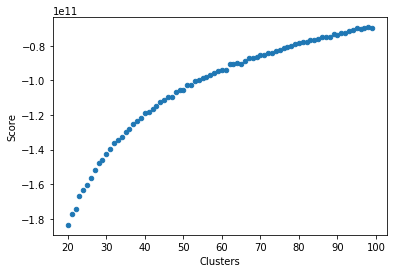

In [6]:
# Creating elbowplot over attrbutes
values = []
for i in range(20, 100):
    kmeans = KMeans(n_clusters=i, random_state=0)

    kmeans.fit(data)
    
    values.append([i, kmeans.score(data)])


values = np.array(values)
#values = np.reshape(values, (20,2))

v = pd.DataFrame({'Clusters' : values[:,0], 'Score' : values[:,1]})

v.plot.scatter(x='Clusters', y='Score')

In [7]:
# Kmeans on our attribute
num_clusters = 60
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

kmeans.fit(data)

clusters = [[] for i in range(0,num_clusters)]
for i,k in enumerate(kmeans.labels_):
    clusters[k].append(labelled.values[i][0])

    ## PRINT IVY CLUSTERS
clusters = [[] for i in range(0,num_clusters)]
for i,k in enumerate(kmeans.labels_):
    if labelled.values[i][1] in ivies:
        print(labelled.values[i][0], k)
    if (k == 19 or k == 27 or k == 32 or k == 56):
        clusters[k].append(labelled.values[i][0])
## TO PRINT IVY CLUSTERS
with np.printoptions(precision=3, suppress=True):
    print(kmeans.cluster_centers_[19])
    print(kmeans.cluster_centers_[27])
    print(kmeans.cluster_centers_[32])
    print(kmeans.cluster_centers_[56])
#     print(kmeans.cluster_centers_[25])
for r in clusters:
    print(str(r) + '\n')

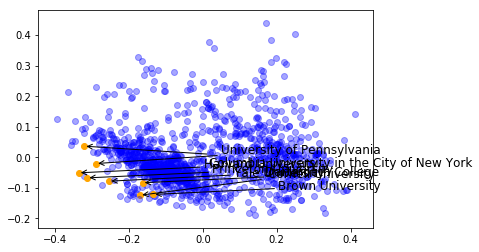

In [14]:
pca = PCA(n_components=2)

p_data = np.array(pca.fit_transform(normalize(data)))

# fig = plt.figure(figsize=(6,6))
# ax = plt.axes()
# #ax.scatter(X[:, 0], X[:, 1], ) # Plot the documents
# # kmeans = KMeans(n_clusters=60, random_state=1)
# # kmeans.fit(p_data)

# # plt.scatter(p_data[:,0], p_data[:,1], c=kmeans.labels_, cmap='tab10', alpha=1)
# # kmeans = KMeans(n_clusters=60, random_state=1)
# # kmeans.fit(p_data)

for i,p in enumerate(p_data):
    if labelled.values[i][1] in ivies:
        plt.scatter(p_data[i,0], p_data[i,1], c='orange', alpha=1)
    else:
        plt.scatter(p_data[i,0], p_data[i,1], c='blue', alpha=0.35)


for i,p in enumerate(p_data):
    if labelled.values[i][1] in ivies:
        y_off = 5
        if "Dartmouth" in labelled.values[i][0]:
            y_off += 15
        if "Columbia" in labelled.values[i][0]:
            y_off -= 25
        if "Penn" in labelled.values[i][0]:
            y_off += 5
        plt.annotate(
            labelled.values[i][0],
            xy=(p_data[i][0], p_data[i][1]),
            xytext=(125,y_off),
            textcoords='offset points',
            fontsize=12,
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.set_title("College 2D Embeddings")

plt.show()

In [15]:
ivy_indexes = []
for i in range(len(data)):
    if labelled.values[i][1] in ivies:
        ivy_indexes.append(i)
        
def getNearest(ivy_index, embeddings, number_nearest):
    vector = embeddings[ivy_index, :]
    scores = []
    for i in range(0, embeddings.shape[0]):
        if i != ivy_index and i not in ivy_indexes:
            scores.append([i, euclidean(vector, embeddings[i,:])])
    return [labelled.values[x[0]][0] for x in sorted(scores, key=lambda x : x[1])][:number_nearest]


def ivyScore(college, embeddings):
    vector = embeddings[college, :]
    score = 0.0
    for ivy in ivy_indexes:
        score += euclidean(vector, embeddings[ivy,:])
        
    return score

In [33]:
from sklearn.preprocessing import normalize
normed_data = normalize(data)

nearest = 3
top = 10
for i in range(len(data)):
    if labelled.values[i][1] in ivies:
        print(labelled.values[i][0])
        print(getNearest(i, np.array(normed_data), nearest))
        print("--------------------------------------")

college_scores = []
for i in range(len(data)):
    if labelled.values[i][1] not in ivies:
        college_scores.append([labelled.values[i][0], ivyScore(i, np.array(normed_data))])


topSchools = [x[0] for x in sorted(college_scores, key=lambda x : x[1])][:top]
lowSchools = [x[0] for x in sorted(college_scores, key=lambda x : x[1])][-top:]
print("Full Dim Data")
print(topSchools)
print(lowSchools)

Yale University
['Amherst College', 'Wellesley College', 'Stanford University']
--------------------------------------
Harvard University
['Pomona College', 'Stanford University', 'Amherst College']
--------------------------------------
Dartmouth College
['Sarah Lawrence College', 'Georgetown University', 'Rice University']
--------------------------------------
Princeton University
['Pomona College', 'Amherst College', 'Stanford University']
--------------------------------------
Columbia University in the City of New York
['Gallaudet University', 'University of the Pacific', 'LIU Post']
--------------------------------------
Cornell University
['Vanderbilt University', 'Duke University', 'University of Chicago']
--------------------------------------
University of Pennsylvania
['Life University', 'University of Southern California', 'Pomona College']
--------------------------------------
Brown University
['Georgetown University', 'Tufts University', 'Colgate University']
----------

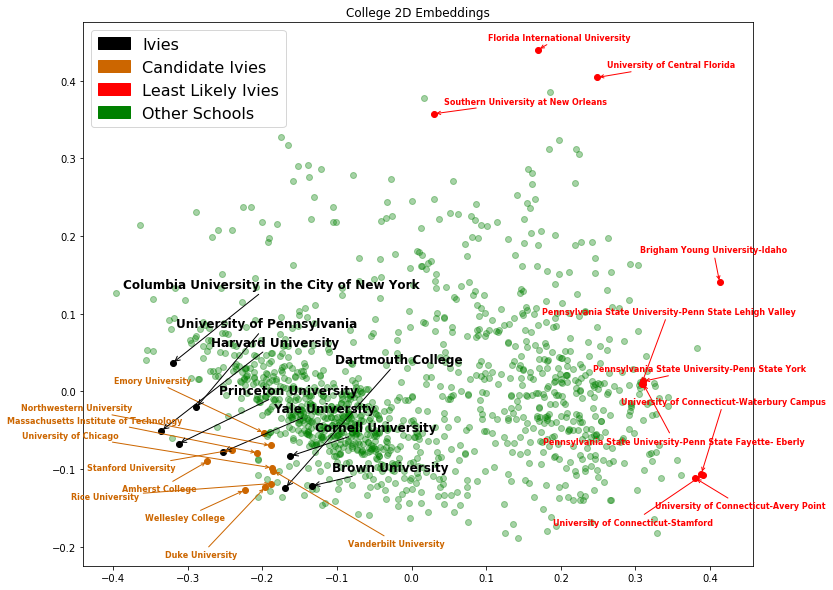

In [40]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes()

oran = "#cc6600"
for i,p in enumerate(p_data):
    if labelled.values[i][1] in ivies:
        plt.scatter(p_data[i,0], p_data[i,1], c='black', alpha=1)
    elif labelled.values[i][0] in topSchools:
        plt.scatter(p_data[i,0], p_data[i,1], c=oran, alpha=1)
    elif labelled.values[i][0] in lowSchools:
        plt.scatter(p_data[i,0], p_data[i,1], c='red', alpha=1)
    else:
        plt.scatter(p_data[i,0], p_data[i,1], c='green', alpha=0.35)


loc = {
    "Brown University" : [20, 15],
    "Dartmouth College" : [50, 125],
    "Harvard University" : [50, 85],
    "Princeton University" : [40, 50],
    "Yale University" : [50, 40],
    "Cornell University" : [25, 25],
    "Columbia University in the City of New York" : [-50, 75],
    "University of Pennsylvania" : [-20, 80],
    
    "Amherst College" : [-85, -30],
    'Stanford University': [-145, -20],
    'University of Chicago': [-250, 30],
    'Massachusetts Institute of Technology': [-250, 30],
    'Vanderbilt University': [75, -75],
    'Wellesley College': [-100, -30],
    'Duke University': [-100, -70],
    'Emory University': [-150, 50], 
    'Northwestern University': [-250, 35],
    'Swarthmore College': [-75, 40],
    'Rice University': [-200, -15],
    
    'Pennsylvania State University-Penn State York': [-50, 10], 
    'Pennsylvania State University-Penn State Lehigh Valley': [-100, 70],  
    'Pennsylvania State University-Penn State Fayette- Eberly': [-100, -60],  
    'University of Connecticut-Avery Point': [-40, -30],  
    'Florida International University': [-50, 10],  
    'University of Connecticut-Waterbury Campus': [-80, 70],  
    'University of Connecticut-Stamford': [-150, -50],  
    'Brigham Young University-Idaho': [-80, 30],  
    'University of Central Florida': [10, 10],  
    'Southern University at New Orleans': [10, 10] 
}
for i,p in enumerate(p_data):
    if labelled.values[i][0] in topSchools:
        plt.annotate(
            labelled.values[i][0],
            xy=(p_data[i][0], p_data[i][1]),
            xytext=(loc[labelled.values[i][0]][0],loc[labelled.values[i][0]][1]),
            textcoords='offset points',
            fontsize=8,
            fontweight='bold',
            color=oran,
            arrowprops=dict(arrowstyle="->", color=oran))
    
    if labelled.values[i][0] in lowSchools:
        plt.annotate(
            labelled.values[i][0],
            xy=(p_data[i][0], p_data[i][1]),
            xytext=(loc[labelled.values[i][0]][0],loc[labelled.values[i][0]][1]),
            textcoords='offset points',
            fontsize=8,
            fontweight='bold',
            color='red',
            arrowprops=dict(arrowstyle="->", color='red'))
    
    if labelled.values[i][1] in ivies:
        plt.annotate(
            labelled.values[i][0],
            xy=(p_data[i][0], p_data[i][1]),
            xytext=(loc[labelled.values[i][0]][0],loc[labelled.values[i][0]][1]),
            textcoords='offset points',
            fontsize=12,
            fontweight='bold',
            arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.set_title("College 2D Embeddings")

black_patch = mpatches.Patch(color='black', label='Ivies')
orange_patch = mpatches.Patch(color=oran, label='Candidate Ivies')
green_patch = mpatches.Patch(color='green', label='Other Schools')
red_patch = mpatches.Patch(color='red', label='Least Likely Ivies')


plt.legend(handles=[black_patch, orange_patch, red_patch, green_patch], loc='upper left', prop={'size': 16})

plt.savefig('college_chart.png')
plt.show()

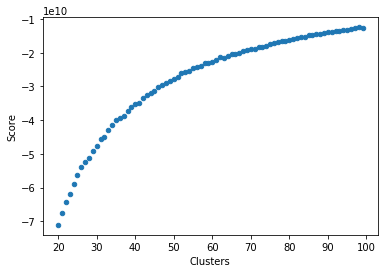

In [36]:
values = []
for i in range(20, 100):
    kmeans = KMeans(n_clusters=i, random_state=0)

    kmeans.fit(p_data)
    
    values.append([i, kmeans.score(p_data)])


values = np.array(values)
#values = np.reshape(values, (20,2))

v = pd.DataFrame({'Clusters' : values[:,0], 'Score' : values[:,1]})

v.plot.scatter(x='Clusters', y='Score')

In [11]:
def uniq(labels):
    labs = set()
    for i in range(len(labels)):
        if labelled.values[i][1] in ivies:
            labs.add(labels[i])
    return len(labs)

# kmeans = KMeans(n_clusters=60, random_state=0)

# kmeans.fit(p_data)

# print(uniq(kmeans.labels_))
    
values = []
for i in range(0, 100):
    kmeans = KMeans(n_clusters=60, random_state=i)

    kmeans.fit(p_data)
    
    values.append([i, uniq(kmeans.labels_), kmeans.score(p_data)])

print(values)

[[0, 4, -22642894189.65805], [1, 4, -22430784560.31921], [2, 4, -22380314130.136436], [3, 4, -22163243480.589348], [4, 4, -22359520808.656136], [5, 4, -22310071672.188362], [6, 4, -22240148215.055557], [7, 5, -22458372579.078793], [8, 5, -22598538011.662502], [9, 5, -22300223230.406414], [10, 5, -22819653877.95549], [11, 5, -22554091698.861347], [12, 4, -22352791009.41182], [13, 5, -22471945640.823986], [14, 4, -22495133456.21296], [15, 5, -22570769887.548225], [16, 5, -22533412817.255455], [17, 4, -22346483502.249928], [18, 4, -22041492360.44716], [19, 4, -22405667037.28942], [20, 5, -22297577220.164185], [21, 5, -22613157722.96833], [22, 5, -22587552003.90648], [23, 4, -22505494771.511734], [24, 5, -22359370367.13468], [25, 5, -22486582755.20845], [26, 5, -22067297858.94172], [27, 4, -22448101390.023422], [28, 5, -22571629666.84974], [29, 5, -22169689687.474396], [30, 5, -22286371130.752537], [31, 5, -22564820590.28167], [32, 4, -22292084767.495678], [33, 5, -22549857941.624367], [34